# Read input files and define function

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

#==============================================================================
#  Define EMSC
#==============================================================================
#%% Extended multiplicative signal correction
def EMSC(X, reference, degree=4):
    # Create polynomials up to chosen degree
    poly = []; pvar = [1]
    for i in range(degree):
        poly.append( np.polyval(pvar,np.linspace(-1,1,len(reference))) )
        pvar.append(0)
    # Reference spectrum and polynomials
    emsc_basis = np.vstack([reference, np.vstack(poly)])
    # Estimate EMSC parameters
    (params,_,_,_) = np.linalg.lstsq(emsc_basis.T, X.T, rcond=None)
    # Correct and return
    return (X - params[1:,:].T @ emsc_basis[1:,:])/params[:1,:].T


#==============================================================================
#  Read train and test file
#==============================================================================
pickle_train = open("train.pkl","rb")
train_object = pickle.load(pickle_train)
pickle_test = open("test.pkl","rb")
test_object = pickle.load(pickle_test)

#==============================================================================
#  Read dictionary objects into arrays and Matrices
#==============================================================================
columns = train_object['shifts'].flatten()
X_train = train_object['RamanCal']
y_train = train_object['IodineCal']
replicates_train = train_object['repCal']

X_test = test_object['RamanVal']
replicates_test = test_object['repVal']

# Technical preprocessing

In [2]:
#==============================================================================
#  Keep only the shifts between 500 and 3100- train aand test
#==============================================================================
X_cut_train = X_train[ :, (columns>=500) & (columns<=3100)]
colnames = columns[ (columns>=500) & (columns<=3100) ]
X_emsc_train = EMSC(X_cut_train, X_cut_train[1343, :]  , degree=7)

X_cut_test = X_test[ :, (columns>=500) & (columns<=3100)]
X_emsc_test = EMSC(X_cut_test, X_cut_train[1343, :]  , degree=7)

# Creating DataFrames which are used later

In [3]:
#==============================================================================
#  Create dataframes for data visualization
#==============================================================================
col_str = list( map( str, colnames))
col_str.insert(0,'replicates')

test_df = pd.DataFrame( np.concatenate( (replicates_test[:, np.newaxis ]
            , X_emsc_test), axis =1), columns= col_str)

col_str.append('Iodine')

train_df = pd.DataFrame( np.concatenate( (replicates_train[:, np.newaxis ]
            , X_emsc_train, y_train), axis =1)
            , columns= col_str)

# Some EDA 
- Since they have similar standard deviation and mean, we could say that the train set and test set are similar.
- Just the minimum value seems to be much lesser in case of train data

In [4]:
print('Train data:')
print( 'Max: ', X_emsc_train.max(),'Min: ',X_emsc_train.min(),'Avg: ' , X_emsc_train.mean(),'Std: ' , X_emsc_train.std() )
print('Test data:')
print( 'Max', X_emsc_test.max(),'Min', X_emsc_test.min(),'Avg: ' , X_emsc_test.mean() ,'Std: ' , X_emsc_test.std() )

Train data:
Max:  55733.27612485042 Min:  1581.9135386188814 Avg:  9578.707219530945 Std:  7450.607883448042
Test data:
Max 59184.6262267195 Min 3220.7337720180763 Avg:  9578.707219530937 Std:  7448.209530634847


In [5]:
pd.DataFrame(y_train).describe()

,0
count,1796.000000
mean,24.755636
std,3.472541
min,18.387700
25%,22.615000
50%,23.935500
75%,26.365300
max,43.923200


# Plot the train and test spectra

In [6]:
x_axis = train_df.columns[1:-1].astype(np.int)

In [7]:
train_df.iloc[:1 , 1:-1].values.flatten()
print(type(train_df.iloc[:1 , 1:-1].values.flatten()))
print(train_df.iloc[:1 , 1:-1].values.flatten().shape)

<class 'numpy.ndarray'>
(2601,)


In [8]:
train_df['Iodine'][0] 

33.4127

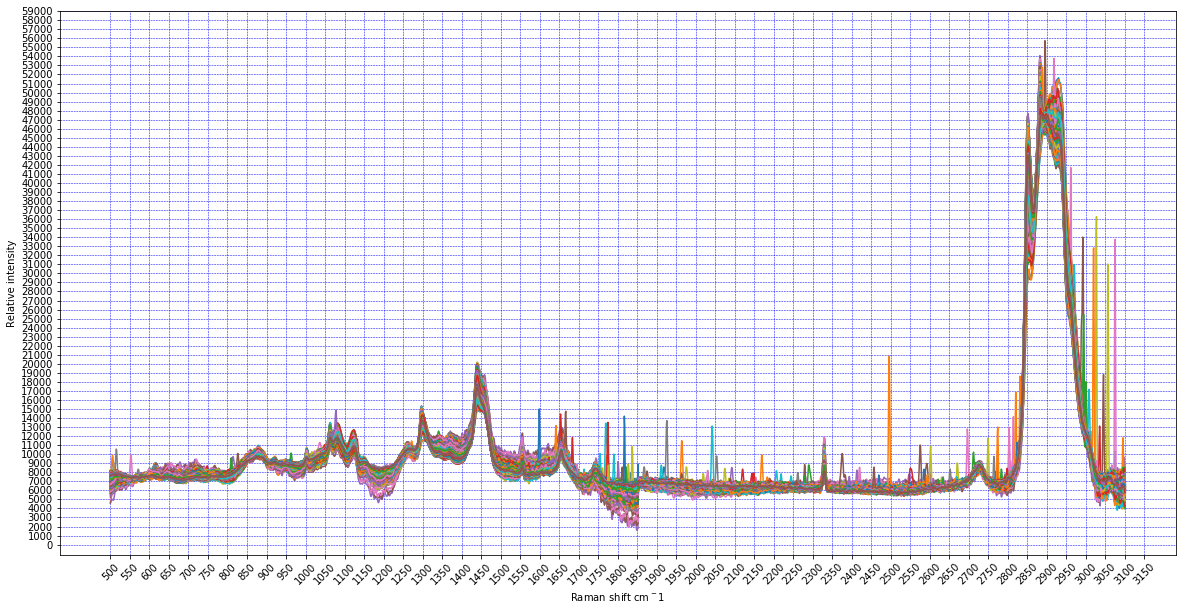

In [9]:
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(train_df.shape[0]):
    plt.plot( x_axis , train_df.iloc[i , 1:-1].values.flatten(),'-'  ) 

plt.xlabel('Raman shift cm$^-1$')
plt.ylabel('Relative intensity')
plt.xticks(np.arange(500, 3200, 50), rotation=45)
plt.yticks(np.arange(0, 60000, 1000))
# Customize the major grid
plt.grid(which='major', linestyle='--', linewidth='0.5', color='blue')
plt.show()

## In test dataset

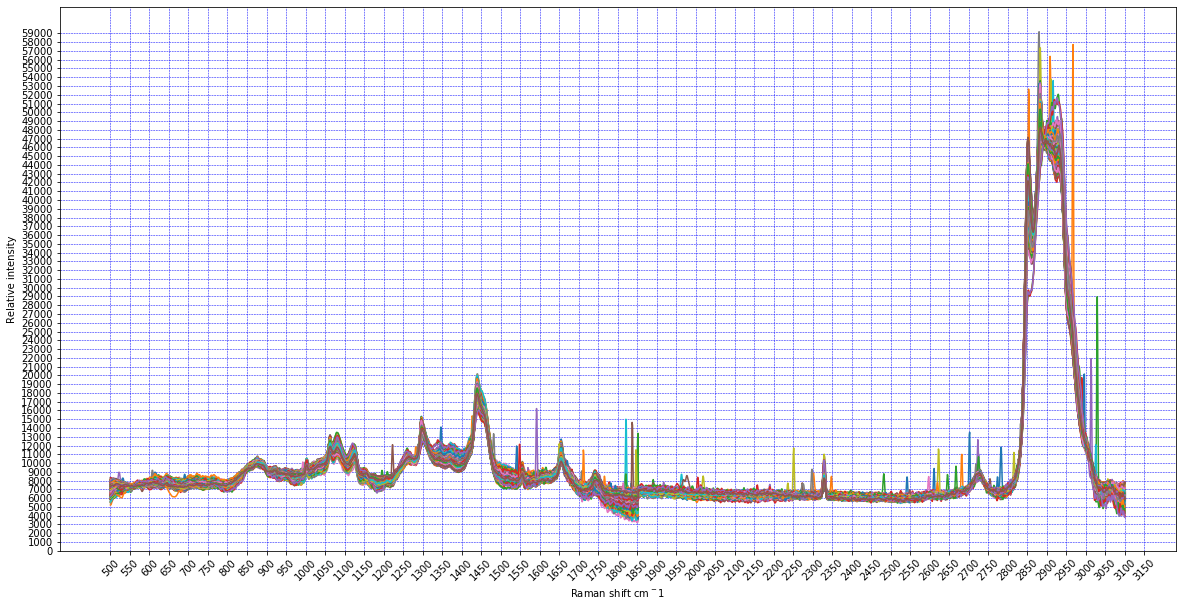

In [10]:
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(test_df.shape[0]):
    plt.plot( x_axis , test_df.iloc[i , 1:].values.flatten(),'-'  ) 

plt.xlabel('Raman shift cm$^-1$')
plt.ylabel('Relative intensity')
plt.xticks(np.arange(500, 3200, 50), rotation=45)
plt.yticks(np.arange(0, 60000, 1000))
# Customize the major grid
plt.grid(which='major', linestyle='--', linewidth='0.5', color='blue')
plt.show()


*There is no significant, but some difference at places between training and test spectrum.*
- **Should we consider these rows as outliers** ?

# Hoggorm PCA plots
- Interactive plots used for better visualization

In [11]:
#==============================================================================
# Loadings and Scores plot Hoggorm, Take average among replicates
# Source: https://github.com/olivertomic/hoggorm/tree/master/examples
#==============================================================================
import hoggorm as ho
import hoggormplot as hop

train_avg_df = train_df.iloc[:, :-1].groupby('replicates').mean()

# Get the values from the data frame
data = train_avg_df.values

# Get the variable or columns names
data_varNames = list(train_avg_df.columns)

# Get the object or row names
data_objNames = list (  map( int, list(train_avg_df.index)) )

model = ho.nipalsPCA(arrX=data, Xstand=False, cvType=["loo"], numComp=4)


loo


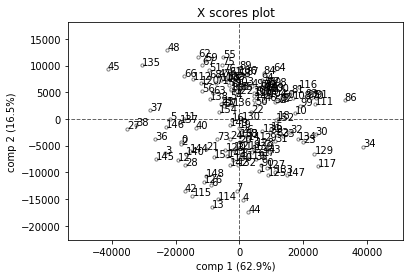

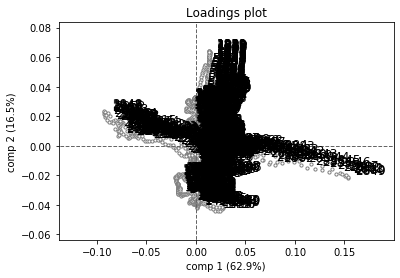

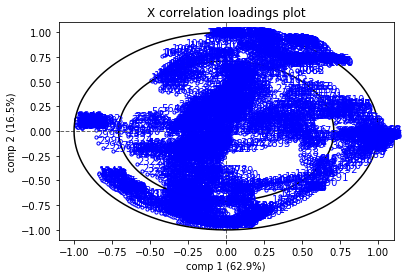

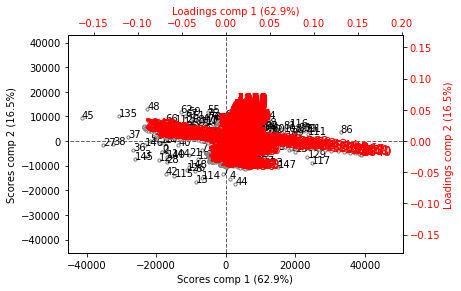

In [12]:
# %matplotlib qt5 # For zooming in and out
%matplotlib inline
hop.plot(model, comp=[1,2], 
         plots=[1,2,3,4], 
         objNames=data_objNames, 
         XvarNames=data_varNames)


**Components 2 and 3 also showed variation and points are more dense in the direction of 2nd and 3rd components, than the first**

# Try with PCA and RandomForestRegression

In [5]:
#==============================================================================
# Trying PCA and Random Forest regression in a gridsearch
#==============================================================================
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

In [14]:
rf_pipe = make_pipeline(  #StandardScaler(),
                        PCA(n_components=10),
                        RandomForestRegressor( n_estimators=100, max_depth= 1000, n_jobs=-1) )

## K fold grouping strategy, Randomising how the groups are assigned

In [15]:
from sklearn.model_selection import GroupKFold
groups = np.asarray( [])
import random
random.seed(3)

# Create 31 groups, 31 cross validations
my_list = list(range(1,32))

for i in  range( 1, 32 ) :
    random_item_from_list =random.choice(my_list)    
    my_list.remove(random_item_from_list)
    lower_limit = (i-1)*5
    upper_limit = (i)*5 
    rand_append_nos = sum ( (train_df.replicates < upper_limit)& (train_df.replicates >=lower_limit) )
    groups = np.concatenate( (groups, np.repeat(random_item_from_list,rand_append_nos)),axis=None ) 
print(len(groups))
print( set(groups))

1796
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0}


In [16]:
gkf = GroupKFold(31)

In [17]:
for train_id, test_id in gkf.split(X_emsc_train, y_train.flatten(), groups):
    print(len(train_id), len( test_id), end=' ; ')

1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1736 60 ; 1737 59 ; 1739 57 ; 1739 57 ; 1739 57 ; 1739 57 ; 1739 57 ; 1739 57 ; 1739 57 ; 1742 54 ; 1742 54 ; 1745 51 ; 1745 51 ; 1748 48 ; 

## Start GridSearchCv

In [27]:
depth_range = [ 80,90,100,110] 
features_range = [4,5,6,7,8,9,10] 

param_grid = [ {'randomforestregressor__max_depth': depth_range
                , 'randomforestregressor__max_features': features_range } ]

gs = GridSearchCV(estimator=rf_pipe,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=gkf,
                n_jobs=-1,
                refit=True,
                iid= True)


In [28]:
gs = gs.fit(X_emsc_train, y_train.flatten(), groups= groups )

In [29]:
print(gs.best_score_)
print(gs.best_params_)

-5.054893068777477
{'randomforestregressor__max_depth': 90, 'randomforestregressor__max_features': 5}


In [30]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=90, max_features=5,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=200, n_jobs=-1,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [32]:
gs.cv_results_['mean_test_score'].reshape(len(depth_range),len(features_range))

array([[-5.14916816, -5.05489307, -5.09031338, -5.21257252, -5.29058598,
        -5.39155983, -5.44598276],
       [-5.1522391 , -5.12653029, -5.15115714, -5.19757256, -5.28296258,
        -5.36998775, -5.45639993],
       [-5.08801749, -5.12465855, -5.16464899, -5.20808523, -5.20744056,
        -5.39429186, -5.42350528],
       [-5.14273944, -5.17411261, -5.16953174, -5.17651408, -5.28168643,
        -5.32147085, -5.50533128]])

**Not a good result from PCA+RandomforestRegressor**

# See how the PCA components look

### In train data

In [33]:
pca = PCA(n_components=6)
X_pca_train = pca.fit_transform(X_emsc_train)
pca_df = pd.DataFrame(X_pca_train)
pca_df['target'] = y_train
pca_df.head()

,0,1,2,3,4,5,target
0,33237.788554,9576.047195,-3883.026800,-8791.757154,-66.141771,4310.093365,33.4127
1,32358.255541,6786.207564,-4790.271952,-9452.544979,148.634825,3766.435093,33.4127
2,32854.379829,4855.204003,-4670.587914,-9369.717210,-257.841745,3596.536654,33.4127
3,3445.199374,12604.384413,1450.167995,-11021.558208,-78.887585,1275.680288,33.4127
4,3932.135845,10723.921534,1574.407421,-10844.116439,-135.746603,1132.196623,33.4127


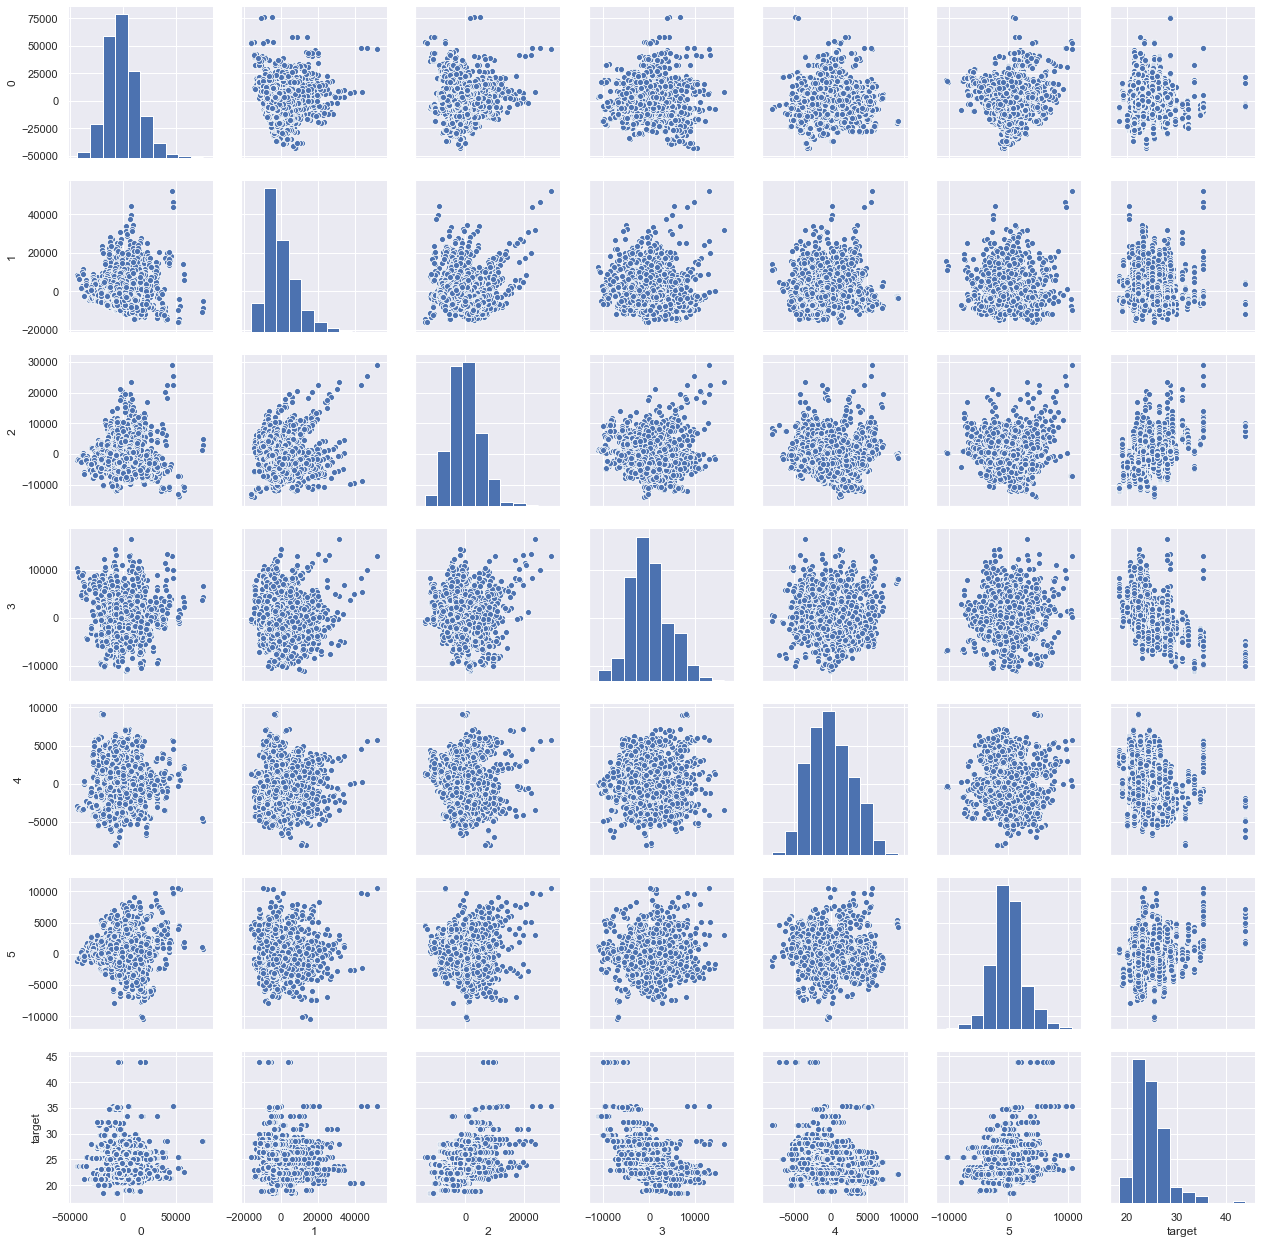

In [34]:
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
sns.pairplot( pca_df  )

**It seems only principal components 3rd and 4th ( feature 2 and 3 in the dataframe) show some structure with respect to the target variable. Let us predict the target using these two features only, both in train and test dataset**

In [35]:
rf_34_fit = RandomForestRegressor( n_estimators=20, max_depth= 10, n_jobs=-1)

In [36]:
rf_34_fit.fit( pca_df.iloc[:, [2,3]] , y_train.flatten() )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [37]:
mean_squared_error( y_train , rf_34_fit.predict( pca_df.iloc[:, [2,3]]  ) )

2.2002475666212904

In [38]:
X_pca_test = pca.fit_transform(X_emsc_test)
pca_test_df = pd.DataFrame(X_pca_test)
pca_test_df.head()

,0,1,2,3,4,5
0,1543.542534,1801.497102,-4475.113594,-696.862154,770.640541,2047.521381
1,2240.465394,-35.524452,-4738.191565,-1072.619965,912.380350,2534.327821
2,2438.337232,-889.180757,-4632.197674,-880.487896,899.525913,2308.480741
3,7738.053883,35677.171568,-792.890989,-1819.563440,-1617.891248,-946.916586
4,7524.770415,31020.981966,-2049.172271,-1778.133701,-1726.111026,-465.214026


### In train data

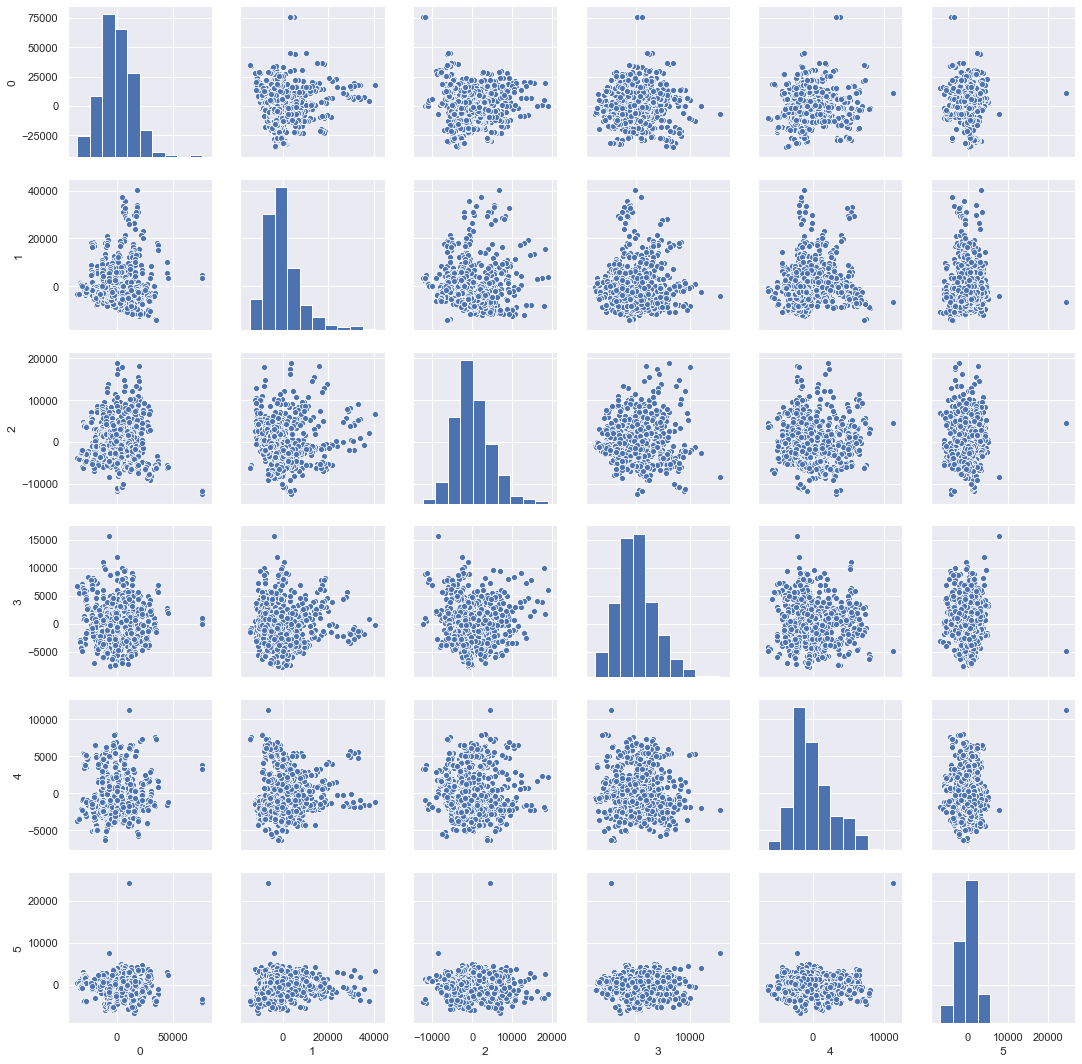

In [39]:
sns.pairplot( pca_test_df  )

In [40]:
y_test_pred = rf_34_fit.predict( pca_test_df.iloc[:, [2,3]]  )
output = pd.DataFrame( y_test_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("submission_ca05_pca_rf_8.csv", index=False)

**Gave a score of 3.5**

# More PCA

In [41]:
# Try running with just the averages
train_avg_df = train_df.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_df.iloc[:, :].groupby('replicates').mean()

In [42]:
rf_pipe = make_pipeline(  #StandardScaler(),
                        PCA(n_components=10),
                        RandomForestRegressor( n_estimators=200, max_depth= 10, n_jobs=-1) )

In [43]:
depth_range = [ 5,10,20,40] 
features_range = [4,5,6,7,8,9,10] 

param_grid = [ {'randomforestregressor__max_depth': depth_range
                , 'randomforestregressor__max_features': features_range } ]

gs = GridSearchCV(estimator=rf_pipe,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                iid= True)


In [44]:
gs = gs.fit( train_avg_df.iloc[:, :-1] ,train_avg_df.iloc[:, -1:].values.flatten()  )

In [45]:
print(gs.best_score_)
print(gs.best_params_)

-4.603091846655235
{'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 6}


In [46]:
y_test_pred = gs.predict( test_avg_df.iloc[:, :]  )
output = pd.DataFrame( y_test_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("submission_pca_avg.csv", index=False)

**Got around 2.27 with this one**

# PLSR

In [48]:
pls6 = PLSRegression(n_components=25, scale=False, max_iter= 5000)
pls6.fit(X_emsc_train, y_train.flatten() )

PLSRegression(copy=True, max_iter=5000, n_components=25, scale=False, tol=1e-06)

In [49]:
print( mean_squared_error(y_train.flatten(), pls6.predict(X_emsc_train) ))
y_test_pred = pls6.predict(X_emsc_test)

0.39978828976528963


In [50]:
comp_range = [ 14,15,16,17,18] 
scale_range = [True, False] 
max_iter_range = [200,300,500]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range}
             ]


gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=gkf,
                n_jobs=-1,
                refit=True,
                 iid=False)

gs.fit(X_emsc_train, y_train.flatten() ,groups=groups)


GridSearchCV(cv=GroupKFold(n_splits=31), error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('plsregression',
                                        PLSRegression(copy=True, max_iter=500,
                                                      n_components=2,
                                                      scale=True, tol=1e-06))],
                                verbose=False),
             iid=False, n_jobs=-1,
             param_grid=[{'plsregression__max_iter': [200, 300, 500],
                          'plsregression__n_components': [14, 15, 16, 17, 18],
                          'plsregression__scale': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [51]:
print(gs.best_score_)
print(gs.best_params_)
gs.best_estimator_

-1.254937011823691
{'plsregression__max_iter': 200, 'plsregression__n_components': 14, 'plsregression__scale': False}


Pipeline(memory=None,
         steps=[('plsregression',
                 PLSRegression(copy=True, max_iter=200, n_components=14,
                               scale=False, tol=1e-06))],
         verbose=False)

In [52]:
gs.cv_results_['mean_test_score']

array([-1.358037  , -1.25493701, -1.41796474, -1.26167693, -1.46598534,
       -1.2949262 , -1.51027922, -1.33643822, -1.55640473, -1.38796118,
       -1.358037  , -1.25493701, -1.41796474, -1.26167693, -1.46598534,
       -1.2949262 , -1.51027922, -1.33643822, -1.55640473, -1.38796118,
       -1.358037  , -1.25493701, -1.41796474, -1.26167693, -1.46598534,
       -1.2949262 , -1.51027922, -1.33643822, -1.55640473, -1.38796118])

In [53]:
gs=  PLSRegression(copy=True, max_iter=200, n_components=14,
                               scale=False, tol=1e-06)
gs.fit(X_emsc_train, y_train.flatten() )

PLSRegression(copy=True, max_iter=200, n_components=14, scale=False, tol=1e-06)

In [54]:
output = pd.DataFrame( y_test_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("submission_ca05_10.csv", index=False)

**This one gave 1.27 in kaggle**

# More PLSR - second best prediction

In [12]:
train_avg_df = train_df.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_df.iloc[:, :].groupby('replicates').mean()

In [13]:
pls_avg =  PLSRegression(copy=True, max_iter=500, n_components=16,
                               scale=False, tol=1e-06)

In [14]:
comp_range = [ 14,15,16,17,18] 
scale_range = [True, False] 
max_iter_range = [10,20,50,100,500]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range} ]

gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                iid= False)

gs.fit( train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values )

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('plsregression',
                                        PLSRegression(copy=True, max_iter=500,
                                                      n_components=2,
                                                      scale=True, tol=1e-06))],
                                verbose=False),
             iid=False, n_jobs=-1,
             param_grid=[{'plsregression__max_iter': [10, 20, 50, 100, 500],
                          'plsregression__n_components': [14, 15, 16, 17, 18],
                          'plsregression__scale': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [15]:
print(gs.best_score_)
print(gs.best_params_)
gs.best_estimator_

-0.34293430892609794
{'plsregression__max_iter': 10, 'plsregression__n_components': 14, 'plsregression__scale': False}


Pipeline(memory=None,
         steps=[('plsregression',
                 PLSRegression(copy=True, max_iter=10, n_components=14,
                               scale=False, tol=1e-06))],
         verbose=False)

In [16]:
output = pd.DataFrame( gs.predict( test_avg_df.iloc[:,:].values))
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("avg_plsr_1.csv", index=False)

**MSE on the train dataset. Overfitting??**

In [17]:
mean_squared_error(  train_avg_df['Iodine'].values , gs.predict( train_avg_df.iloc[:,:-1].values )  )

0.052466510927491945

# Outlier consideration - Best prediction

## In Train data

In [61]:
pot_outlier =  np.asarray(  np.where( (x_axis<=2650) & ( x_axis>1800  )  ) ).flatten()
bool_mat = X_emsc_train[:, pot_outlier ]>12000
print(bool_mat.shape)
outlier_present = []
for i, row in enumerate(bool_mat):
    if sum(row)>0:
        outlier_present.append(i)

pot_outlier =  np.asarray(  np.where(  x_axis>3000  )  ).flatten()
bool_mat = X_emsc_train[:, pot_outlier ]>25000
print(bool_mat.shape)
for i, row in enumerate(bool_mat):
    if sum(row)>0:
        print('yes')
        outlier_present.append(i)

outliers_rows = set(outlier_present)

(1796, 850)
(1796, 100)
yes
yes
yes
yes


In [62]:
print( outliers_rows)

{736, 801, 611, 1418, 459, 18, 1790, 767}


In [63]:
train_dfo = train_df.drop( outliers_rows )
train_dfo.shape

(1788, 2603)

## In Test Data

In [64]:
pot_outlier =  np.asarray(  np.where( (x_axis<=2650) & ( x_axis>1800  )  ) ).flatten()
bool_mat = X_emsc_test[:, pot_outlier ]>12000
print(bool_mat.shape)
outlier_present = []
for i, row in enumerate(bool_mat):
    if sum(row)>0:
        outlier_present.append(i)

pot_outlier =  np.asarray(  np.where(  x_axis>3000  )  ).flatten()
bool_mat = X_emsc_test[:, pot_outlier ]>25000
print(bool_mat.shape)
for i, row in enumerate(bool_mat):
    if sum(row)>0:
        print('yes')
        outlier_present.append(i)

outliers_rows = set(outlier_present)

(886, 850)
(886, 100)
yes


In [65]:
print( outliers_rows)

{162, 339, 252, 325}


In [66]:
test_dfo = test_df.drop( outliers_rows )
test_dfo.shape

(882, 2602)

## Now , after removing outlier and run PLSR

In [67]:
train_avg_df = train_dfo.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_dfo.iloc[:, :].groupby('replicates').mean()

In [68]:
pls_avg =  PLSRegression(copy=True, max_iter=500, n_components=16,
                               scale=False, tol=1e-06)

In [69]:
comp_range = [10,11,12,13, 14,15,16] 
scale_range = [True, False] 
max_iter_range = [50,60,80,90,100,500]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range} ]

gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                 iid= False)

gs.fit( train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values )

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('plsregression',
                                        PLSRegression(copy=True, max_iter=500,
                                                      n_components=2,
                                                      scale=True, tol=1e-06))],
                                verbose=False),
             iid=False, n_jobs=-1,
             param_grid=[{'plsregression__max_iter': [50, 60, 80, 90, 100, 500],
                          'plsregression__n_components': [10, 11, 12, 13, 14,
                                                          15, 16],
                          'plsregression__scale': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [70]:
print(gs.best_score_)
print(gs.best_params_)
gs.best_estimator_

-0.3314359555217047
{'plsregression__max_iter': 50, 'plsregression__n_components': 14, 'plsregression__scale': False}


Pipeline(memory=None,
         steps=[('plsregression',
                 PLSRegression(copy=True, max_iter=50, n_components=14,
                               scale=False, tol=1e-06))],
         verbose=False)

In [71]:
output = pd.DataFrame( gs.predict( test_avg_df.iloc[:,:].values))
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("avg_plsr_outlier4.csv", index=False)

**MSE on the train dataset. Overfitting??**

In [72]:
mean_squared_error(  train_avg_df['Iodine'].values , gs.predict( train_avg_df.iloc[:,:-1].values )  )

0.051511552008470705

# Bagging

In [73]:
from sklearn.ensemble import BaggingRegressor

In [74]:
clf = BaggingRegressor(base_estimator=PLSRegression(
                    n_components=14,
                    scale=False, tol=1e-06),
                    n_estimators=500,
                    random_state=0,
                    n_jobs = -1 ).fit(
    train_avg_df.iloc[:,:-1].values 
    , train_avg_df['Iodine'].values)

y_pred = clf.predict( test_avg_df.iloc[:,:].values)

In [75]:
output = pd.DataFrame( y_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("avg_plsrb.csv", index=False)

In [76]:
mean_squared_error( train_avg_df['Iodine'].values , clf.predict( train_avg_df.iloc[:,:-1].values ) )

0.078449204441567

# More PLSR

In [77]:
train_avg_df = train_df.iloc[:, :].groupby('replicates').median()
test_avg_df = test_df.iloc[:, :].groupby('replicates').median()

In [78]:
comp_range = [ 14,15,16,17,18,24,32] 
scale_range = [True, False] 
max_iter_range = [10,20,50,100,500]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range} ]

gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                iid= True)

gs.fit( train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values )

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('plsregression',
                                        PLSRegression(copy=True, max_iter=500,
                                                      n_components=2,
                                                      scale=True, tol=1e-06))],
                                verbose=False),
             iid=True, n_jobs=-1,
             param_grid=[{'plsregression__max_iter': [10, 20, 50, 100, 500],
                          'plsregression__n_components': [14, 15, 16, 17, 18,
                                                          24, 32],
                          'plsregression__scale': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [79]:
print(gs.best_score_)
print(gs.best_params_)
gs.best_estimator_

-0.5163384604268327
{'plsregression__max_iter': 10, 'plsregression__n_components': 16, 'plsregression__scale': False}


Pipeline(memory=None,
         steps=[('plsregression',
                 PLSRegression(copy=True, max_iter=10, n_components=16,
                               scale=False, tol=1e-06))],
         verbose=False)

In [80]:
# gs = PLSRegression(copy=True, max_iter=500, n_components=24,
#                                scale=False, tol=1e-06).fit(
# train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values)

In [81]:
output = pd.DataFrame( gs.predict( test_avg_df.iloc[:,:].values))
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("med_plsr_1.csv", index=False)

**MSE on the train dataset. Overfitting??**

In [82]:
mean_squared_error(  train_avg_df['Iodine'].values , gs.predict( train_avg_df.iloc[:,:-1].values )  )

0.010353470440900955